# Mistura de Especialistas
Alex Cecconi

----------------------------------
Pre-Processamento dos Dados

In [131]:
#Importa pacotes
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
import random

In [2]:
#Importa Base
df = pd.read_csv(r"C:\Users\Alex\Desktop\Aprendizado_de_Maquina\Insumos\mistura_especialista_conj_treinamento.txt", header=None)
df.columns = ['y']

In [3]:
#Cria os atrasos, cada coluna passa a ser y - i atrasos
for i in range(1,20):
    df['y_' +  str(i)] = df['y'].shift(i)

In [4]:
#Retira vazios
df = df.dropna()

In [46]:
#Independente do metodo, o Lag 2 tem amior correlação
df.corr(method = 'pearson').values[0] # Win - Lag2
df.corr(method = 'kendall').values[0] # Win - Lag2
df.corr(method = 'spearman').values[0] # Win - Lag2

array([ 1.        , -0.34536163,  0.27978446, -0.26659743,  0.23343801,
       -0.19083354,  0.22261732, -0.16082534,  0.20535976, -0.12390507,
        0.10348397, -0.16422238,  0.0927533 , -0.04634609,  0.08510368,
       -0.04849092,  0.14762048, -0.06086714,  0.00371275, -0.04704738])

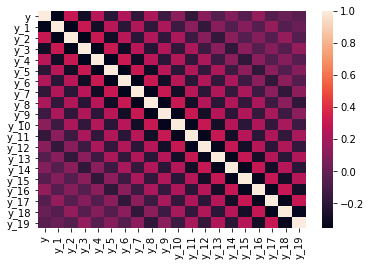

In [56]:
sns.heatmap(df.corr(method = 'pearson'))

In [6]:
#A função de autocorrelação (ACF) é uma medida da aleatoriedade de um sinal 
lag_acf = acf(df.iloc[:,0], nlags=19)

#Função de autocorrelação parcial (FACP), retira efeito da serie de outros lags
lag_pacf = pacf(df.iloc[:,0], nlags=20, method='ols')

#df.corr() #Pearson

Text(0.5, 1.0, 'Autocorrelation Function')

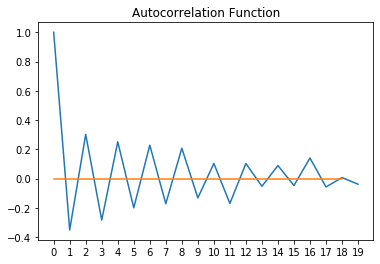

In [7]:
fig, ax = plt.subplots()
plt.plot(lag_acf)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.plot([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

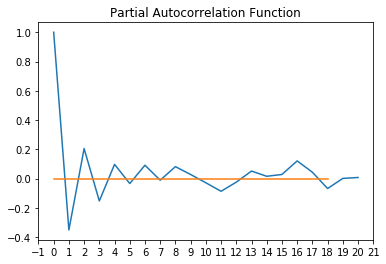

In [8]:
fig, ax = plt.subplots()
plt.plot(lag_pacf)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.plot([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('Partial Autocorrelation Function') 

In [101]:
# No ACF/FACP, pearson, kendall e spearman o Lag 2 demosntrou maior autocorrelação:
Yd = df.iloc[:,0].values
X = df.iloc[:,[2,4,6,8,16]]

---------------------------------
# Modelagem

In [26]:
# m -> numero de especialistas
# X -> matriz de entrada
# Y -> matriz de saida | y_pred
# Yd -> y_real

In [148]:
m    = 3 #Especialista
N    = X.shape[0] #Instancia
ne   = X.shape[1] #Atributo
X    = np.concatenate((X, np.ones((N, 1))), axis=1) # X com Bias
ns   = Yd.reshape(len(Yd),1).shape[1] #Classe
wgat = np.random.normal(0,0.01, size=(m,ne+1)) #Especialista x Atributo + bias

In [150]:
wexp  = [] #ClasseY x Atributo + bias
sigma = [] #Escalar
i=0
for i in range(0,m):
    wexp.append( np.random.normal(0,0.01, size=(ns,ne+1)) )
    sigma.append( random.random() )

In [ ]:
def atualiza_gat(X,h,w,m):
    
    Y = X @ w.T
    g = np.exp(Y)./( np.sum(Y, axis = 1) @ np.ones((1, m)) )
    erro = h - g
    dQdw = erro.T @ X
    alfa, it, itmax = 0.1, 0, 1000
    while numpy.linalg.norm(dQdw) > 1e3 and it < itmax:
        it += 1
        w = w + alfa @ dQdw  
        Y = X*w
        g = np.exp(Y)./( np.sum(Y, axis = 1) @ np.ones((1, m)) )
        erro = h - g
        dQdw = erro.T @ X 
    return w

In [ ]:
def atualiza_exp(X,Yd,h,sig,w,ns):
    Y=X @ w.T
    peso = (h/sigma) * np.ones((1, ns))
    erro = peso * (Yd- Y)
    dQdw = erro.T @ X
    alfa, it, itmax = 0.1, 0, 10:
        while numpy.linalg.norm(dQdw) > 1e3 and it < itmax:
            it = it +1
            w = w + alfa @ dQdw
            Y=X @ w.T
            erro = peso * (Yd- Y)
            dQdw = erro.T @ X
    erro = Yd- Y
    sig= 1/ns @ h.T @ sum(erro * erro, axis = 1)/sum(h)
    return w, sig

In [ ]:
def likelihood(g,p):
    lik = sum(log(sum(g * p, axis = 1))) 
    return lik

In [ ]:
def prob_h(g, p, m):
    num = g * p
    den = sum(num, axis = 1)
    h = num/(den * np.ones((1, m)))
    return h

In [ ]:
def calc_prob_exp(yexp, Yd, sig, m, N):
    for i in range(m):
        Y = yexp[i]
        for n in range(N):
            p[n, i] = np.exp(-(Yd(n,:)-Y(n,:))*(Yd(n,:)-Y(n,:))/sigma[i])
    return p    

In [ ]:
def calc_saida_gat(X,wgat,m):
    ygat = X * wgat.T
    ygat = exp( ygat - np.amax(ygat, axis = 1)) / (sum(exp( ygat - np.amax(ygat, axis = 1)), axis = 1) * np.ones((1, m)) )
    return ygat

In [ ]:
def calc_saida_esp(X, wexp, m):
    for i in range(m):
        yexp[i] = X @ wexp[i].T 
    return yexp

In [ ]:
lik_old = 0
yexp = calc_saida_esp(X, wexp, m)
p = calc_prob_exp(yexp, Yd, sig, m, N)
lik_new = likelihood(ygat, p)
while np.abs(lik_new-lik_old) > 1e3:
    #Passo E - Estimar h
    h = prob_h(ygat, p, m)
    #Passo M
    for i in range(m):
        wexp[i], sigma[i] = atualiza_exp(X, Yd, h[:,i], sig[i], wexp[i], ns)
    wgat = atualiza_gat(X, h, wgat, m)
    yexp = calc_saida_esp(X, wexp, m)
    ygat = calc_saida_gat(X, wgat, m)
    p = calc_prob_exp(yexp, Yd, sig, m, N)
    lik_old = lik_new
    lik_new = likelihood(ygat,p)
    

# Fim
